# Clustering Methods for Excited State Promoted Readout

## Imports

In [3]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ

if not IBMQ.active_account():
    IBMQ.load_account()
    
provider = IBMQ.get_provider(hub='ibm-q-research', group='iiit-2', project='main')
backend = provider.get_backend('ibmq_armonk') # armonk is free pulse backend

In [9]:
from qiskit.visualization import SchedStyle
plot_options={"plot_range": [0,7500],
              "channels": [drive_chan,meas_chan,acq_chan],
              "label": True,
              "style": SchedStyle(figsize=(10,5))}

## Building Backend Characterstics

In [5]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

# device unit sample time
dt = backend_config.dt
qubit = 0
GHz = 1e9
MHz = 1e6
us = 1e-6
ns = 1e-9 # Nanoseconds
scale_factor = 1e-14
NUM_SHOTS = 1024

# get last calibrated qubit frequency
qubit_01_freq_default = backend_defaults.qubit_freq_est[qubit]
print(f"Qubit 0, 0->1 state estimated frequency: {qubit_01_freq_default/GHz} GHz")

Qubit 0, 0->1 state estimated frequency: 4.971855960352799 GHz


## Frequency Sweep $|0\rangle \rightarrow |1\rangle$

In [6]:
import qiskit.pulse as pulse
from qiskit.pulse.library import gaussian
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import SamplePulse
from qiskit.scheduler import measure

def round_16(num):
    return int(num) - int(num)%16

In [7]:
# gaussian parameters
drive_samples_us = 0.075
drive_samples = round_16(drive_samples_us*us/dt)
drive_sigma = round_16(drive_samples_us*8*us/dt)
drive_power = 0.4

ground_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                              sigma=drive_sigma,
                                              amp=drive_power,
                                              name='ground_sweep_drive_pulse')

In [8]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

<ipython-input-10-00656a853aee>:4: DeprecationWarning: "measure" has been moved to "qiskit.pulse.macros"
  sched_01 |= measure([qubit], backend, backend_defaults.instruction_schedule_map, backend_config.meas_map) << sched_01.duration


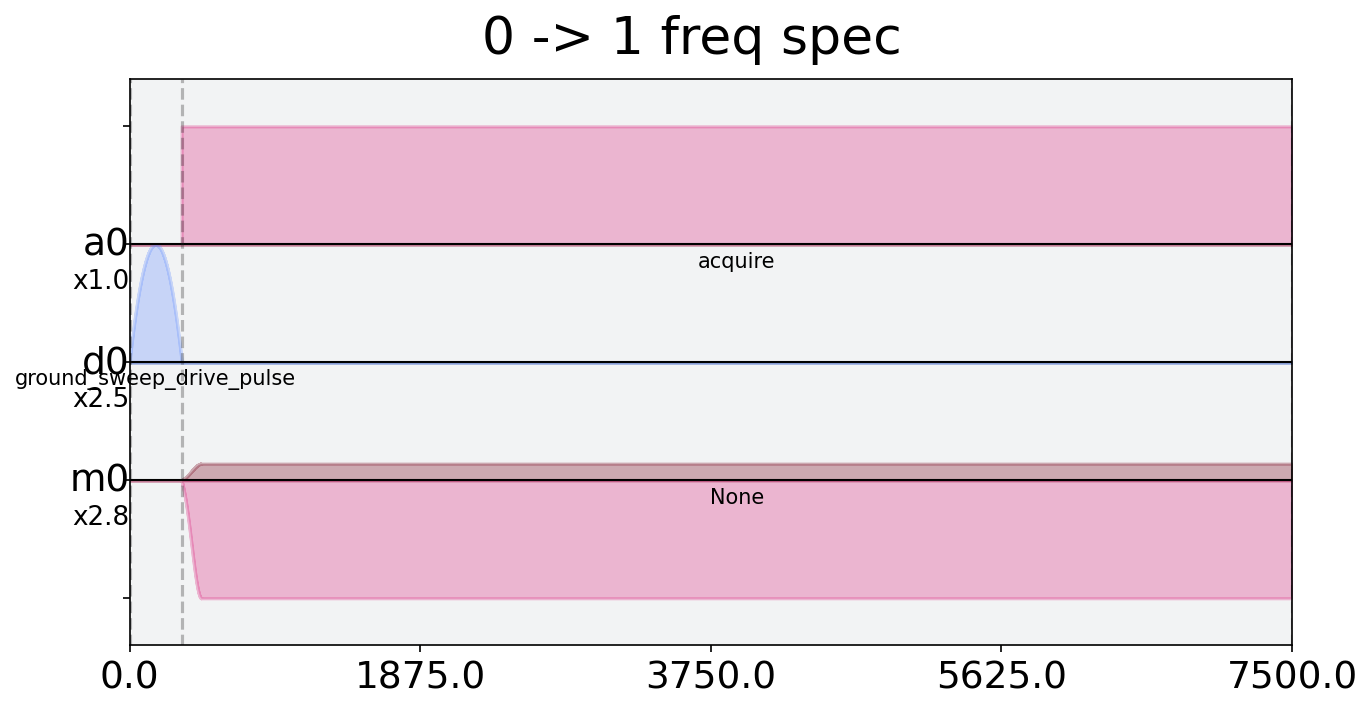

In [10]:
sched_01 = pulse.Schedule(name="0 -> 1 freq spec")
# Start constructing sched_01
sched_01 |= pulse.Play(ground_sweep_drive_pulse, drive_chan)
sched_01 |= measure([qubit], backend, backend_defaults.instruction_schedule_map, backend_config.meas_map) << sched_01.duration
# End constructing

# Visualize sched_01
sched_01.draw(**plot_options)

In [11]:
from qiskit import assemble
freq_range = np.linspace(-20*MHz+qubit_01_freq_default, 20*MHz+qubit_01_freq_default, 75)

# assemble program
freq_sweep_program = assemble(sched_01,
                              backend=backend,
                              meas_level=1,
                              meas_return='avg',
                              shots=1024,
                              schedule_los=[{drive_chan: freq} for freq in freq_range]
                             )

In [12]:
# submit job
freq_sweep_job = backend.run(freq_sweep_program)
freq_sweep_job.update_name("frequency sweep 0->1")

# monitor job progress
from qiskit.tools.monitor import job_monitor
job_monitor(freq_sweep_job)

<ipython-input-12-2e6f414d744a>:2: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  freq_sweep_job = backend.run(freq_sweep_program)


Job Status: job has successfully run


/home/whatsis/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


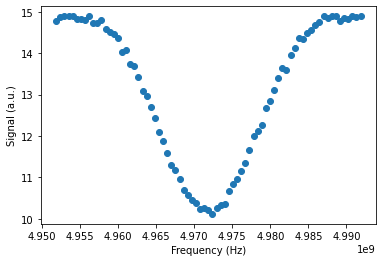

In [13]:
result = freq_sweep_job.result()

scale_factor = 1e-14 # varies by device
data = [result.get_memory(i)[0]*scale_factor for i in range(len(result.results))]

plt.scatter(freq_range,data)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Signal (a.u.)")
plt.show()

/home/whatsis/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Fit parameters: [-1.58920913e+08  4.97186486e+09  8.35258047e+06  1.60807236e+01]


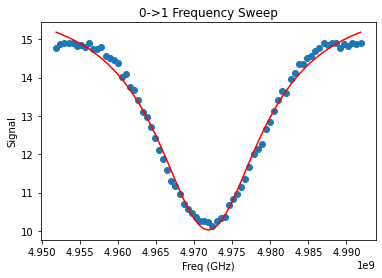

In [14]:
from scipy.optimize import curve_fit

lorentzian = lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C
freq_sweep_fitparams, _ = curve_fit(lorentzian, freq_range, data, [6e7, qubit_01_freq_default, 4e6, -3])
y_fit = lorentzian(freq_range, *freq_sweep_fitparams)
print(f"Fit parameters: {freq_sweep_fitparams}")

plt.scatter(freq_range,data)
plt.plot(freq_range, y_fit, color='red')
plt.title("0->1 Frequency Sweep")
plt.xlabel("Freq (GHz)")
plt.ylabel("Signal")
plt.show()

### Calibrating $|0\rangle \rightarrow |1\rangle$ Frequency

In [15]:
qubit_01_freq_cal = freq_sweep_fitparams[1]
print(f"Updated qubit frequency from {qubit_01_freq_default/GHz} to {qubit_01_freq_cal/GHz} GHz")

Updated qubit frequency from 4.971855960352799 to 4.971864864938466 GHz


## Rabi Experiment: $|0\rangle \rightarrow |1\rangle$

In [26]:
# Rabi experiment parameters
num_rabi_points = 75

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = -0.25
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

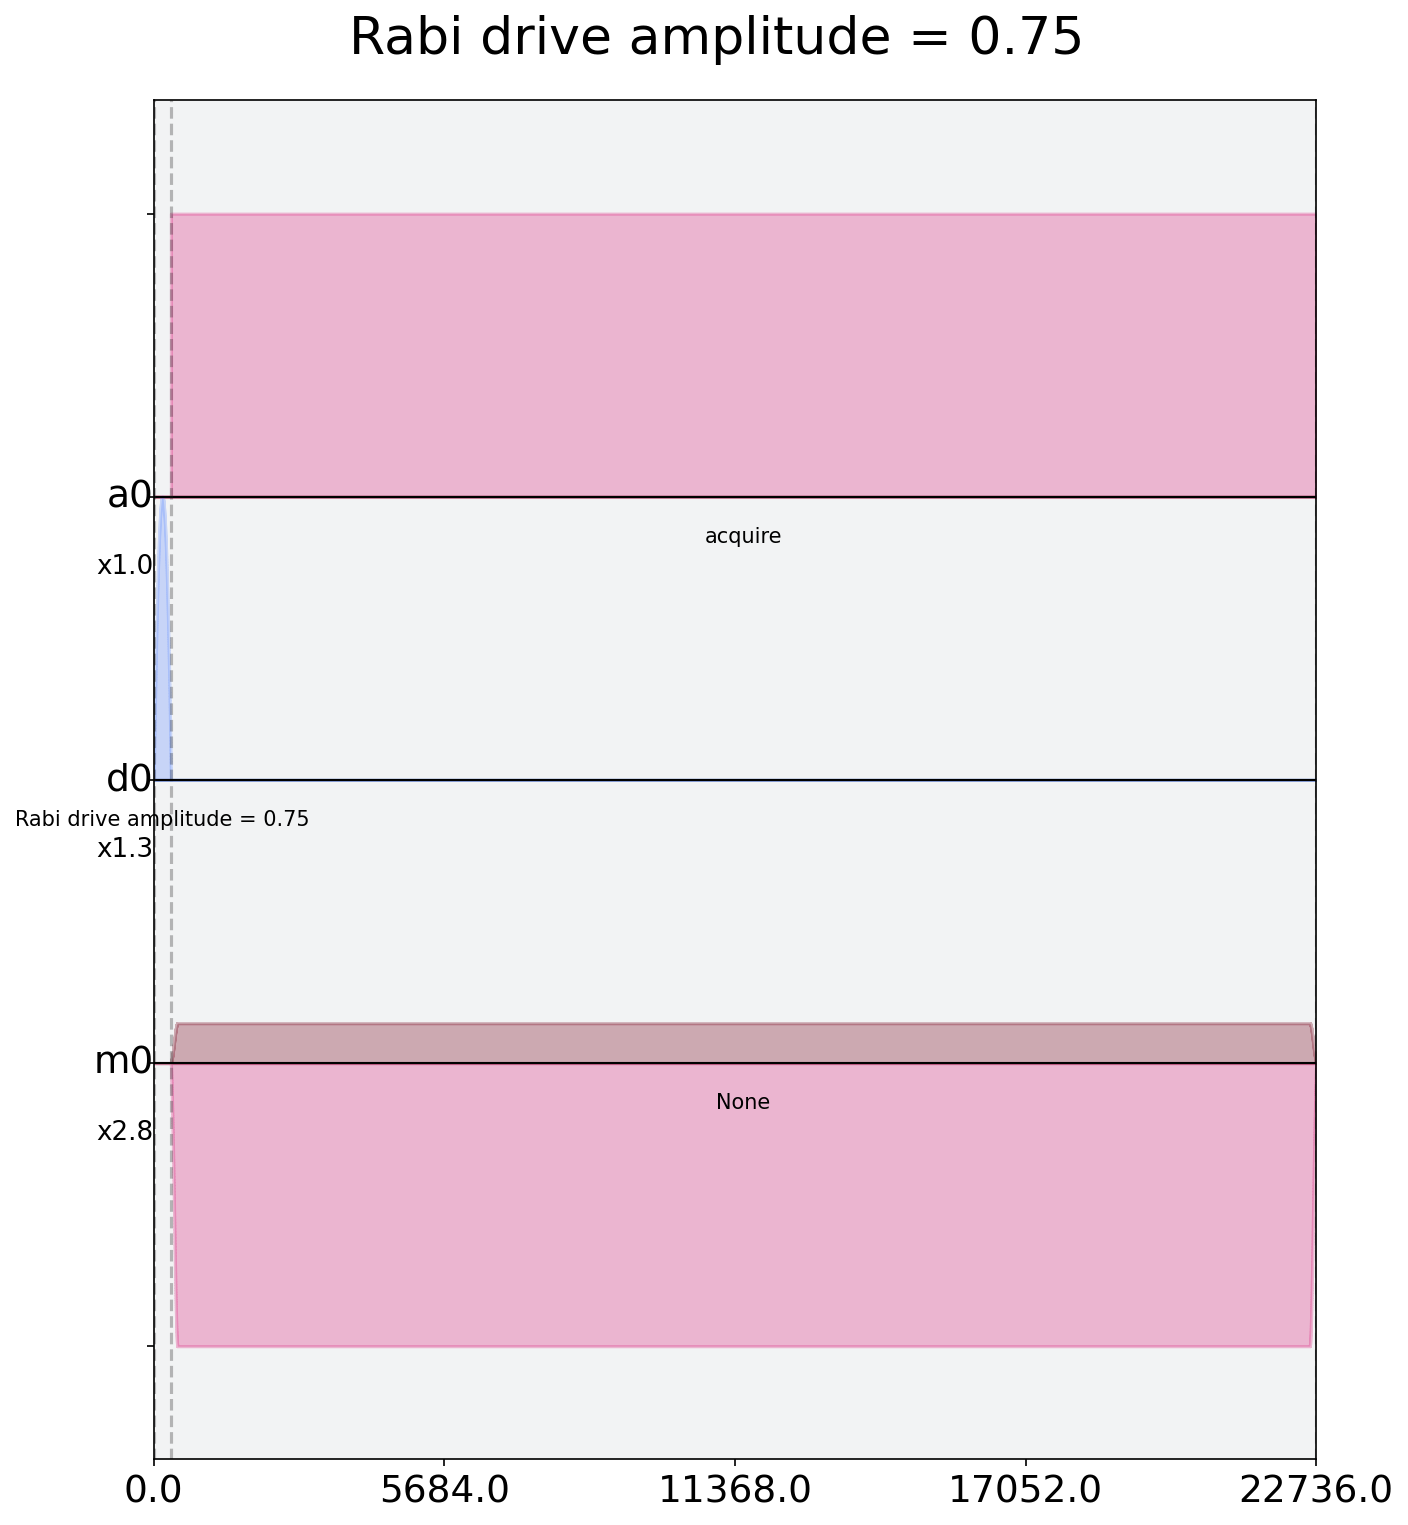

In [27]:
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += pulse.Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure([qubit], backend, backend_defaults.instruction_schedule_map, backend_config.meas_map) << this_schedule.duration
    rabi_schedules.append(this_schedule)
    
rabi_schedules[-1].draw(label=True)


In [28]:
rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=NUM_SHOTS,
                                   schedule_los=[{drive_chan: qubit_01_freq_cal}]
                                                * num_rabi_points)

job = backend.run(rabi_experiment_program)
job_monitor(job)

<ipython-input-28-6f98e88f292a>:9: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(rabi_experiment_program)


Job Status: job has successfully run


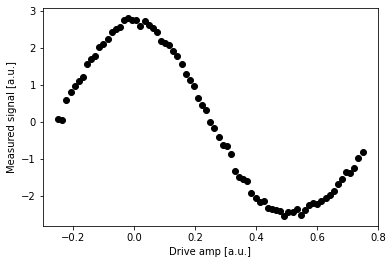

In [30]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)


rabi_results = job.result(timeout=120)
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

In [33]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

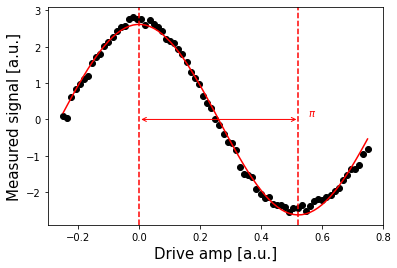

In [47]:
from scipy.optimize import curve_fit

fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.5, 1.5, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(0, color='red', linestyle='--')
plt.axvline(drive_period/2, color='red', linestyle='--')
plt.annotate("", xy=(0, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2+0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()


### Calibrate Amplitude for $\pi$ Pulse

In [50]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.5229874015398489


## Build the ($|0\rangle,\ |1\rangle$) discriminator

In [54]:
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

In [83]:
# Create the two schedules

# Ground state 
zero_schedule = pulse.Schedule(name="cal_0")
zero_schedule |= measure([qubit], backend, backend_defaults.instruction_schedule_map, backend_config.meas_map)

# Excited state schedule
one_schedule = pulse.Schedule(name="cal_1")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan) 
one_schedule |= measure([qubit], backend, backend_defaults.instruction_schedule_map, backend_config.meas_map) << one_schedule.duration

In [84]:
# Assemble the schedules into a program
IQ_01_program = assemble([zero_schedule, one_schedule],
                          backend=backend,
                          meas_level=1,
                          meas_return='single',
                          shots=NUM_SHOTS,
                          schedule_los=[{drive_chan: qubit_01_freq_cal}] * 2)

IQ_01_job = backend.run(IQ_01_program)
job_monitor(IQ_01_job)

<ipython-input-84-1fd8f6f0922a>:9: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  IQ_01_job = backend.run(IQ_01_program)


Job Status: job has successfully run


In [617]:
# Get job data (single); split for zero and one
result = IQ_01_job.result()

# Single shots result
IQ_01_data = [result.get_memory(i)[:,0]*scale_factor for i in range(len(result.results))]
#IQ_01_data = get_job_data(IQ_01_job, average=False)
zero_data = IQ_01_data[0]
one_data = IQ_01_data[1]

In [91]:
with open('res_2_01.npy', 'wb') as f:
    np.save(f, zero_data)
    np.save(f, one_data)


In [76]:
one_data

array([-18.47737612+1.1258855j , -19.85402991-0.22661965j,
       -19.49714228+1.05418102j, ..., -21.85219365+2.34613176j,
       -19.4567602 +0.81553896j, -21.97273056-2.43515854j])

### IQ Plot

In [618]:
def IQ_01_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for |0>, |1>. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')

    # Plot a large dot for the average result of the zero and one states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1 discrimination", fontsize=15)

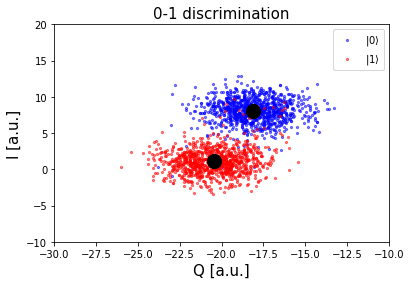

In [619]:
x_min = -30
x_max = -10
y_min = -10
y_max = 20
IQ_01_plot(x_min, x_max, y_min, y_max)

### Classify

(array([<AxesSubplot:title={'center':'Qubit 0'}, xlabel='I (arb. units)', ylabel='Q (arb. units)'>],
       dtype=object),
 None)

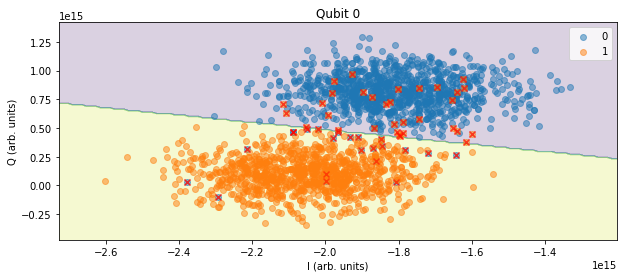

In [90]:
from qiskit.ignis.measurement.discriminator.iq_discriminators import *

fig, ax = plt.subplots(1, 1, figsize=(10,4))

#fig = plt.plot(figsize=(10,4))

# discriminate 0 and 1
discs01 = {}
discs01['LDA'] = LinearIQDiscriminator(result, qubit_mask=[0], schedules=["cal_0", "cal_1"])
discs01['LDA'].plot(ax, show_boundary=True, flag_misclassified=True)

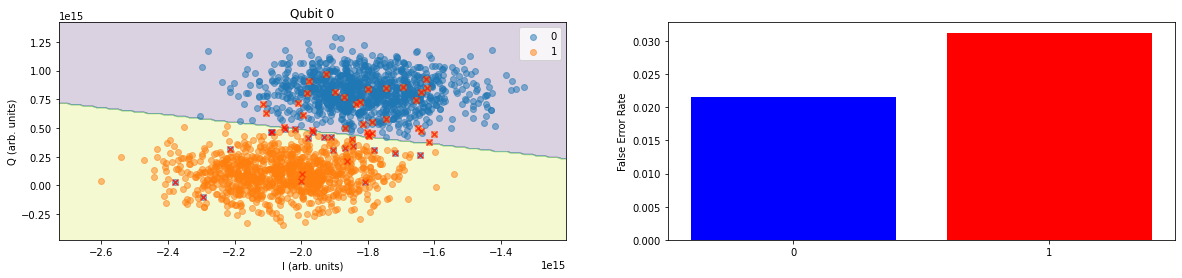

In [624]:
fig, ax = plt.subplots(1, 2, figsize=(20,4))

discs01 = {}
discs01['LDA'] = LinearIQDiscriminator(result, qubit_mask=[0], schedules=["cal_0", "cal_1"])
discs01['LDA'].plot(ax, show_boundary=True, flag_misclassified=True)

ax[1].bar([str(ind) for ind in range(2)], 
          get_accuracy(DiscriminationFilter(discs01['LDA']).apply(result).get_counts()), 
          color=['blue', 'red'])
ax[1].set_xlabel("")
ax[1].set_ylabel("False Error Rate")
plt.show()

## Frequency Sweep $|0\rangle \rightarrow |2\rangle$

To excite the $|0\rangle \rightarrow |2\rangle$ transition, we first excite $|0\rangle$ to the $|1\rangle$ state and then perform the frequency sweep over excitations of the $|1\rangle$ state. A peak (extremum) should be observed at a frequency lower than the $|0\rangle\rightarrow |1\rangle$ frequency that corresponds to the $|1\rangle \rightarrow |2\rangle$ frequency.

Schedules are limited to a single frequency. To drive the $|0\rangle\rightarrow |2\rangle$ $\pi$ transition, we set the local oscillator (LO) frequency to `qubit_01_freq_cal` and multiply a sine function onto the $|1\rangle \rightarrow |2\rangle$ pulse at `freq-qubit_01_freq_cal` to add a modulation at `freq`, the desired scan frequency. Applying the sinusoidal sideband, as it's known, enables us to change the LO frequency without manually setting it when assembling the program.

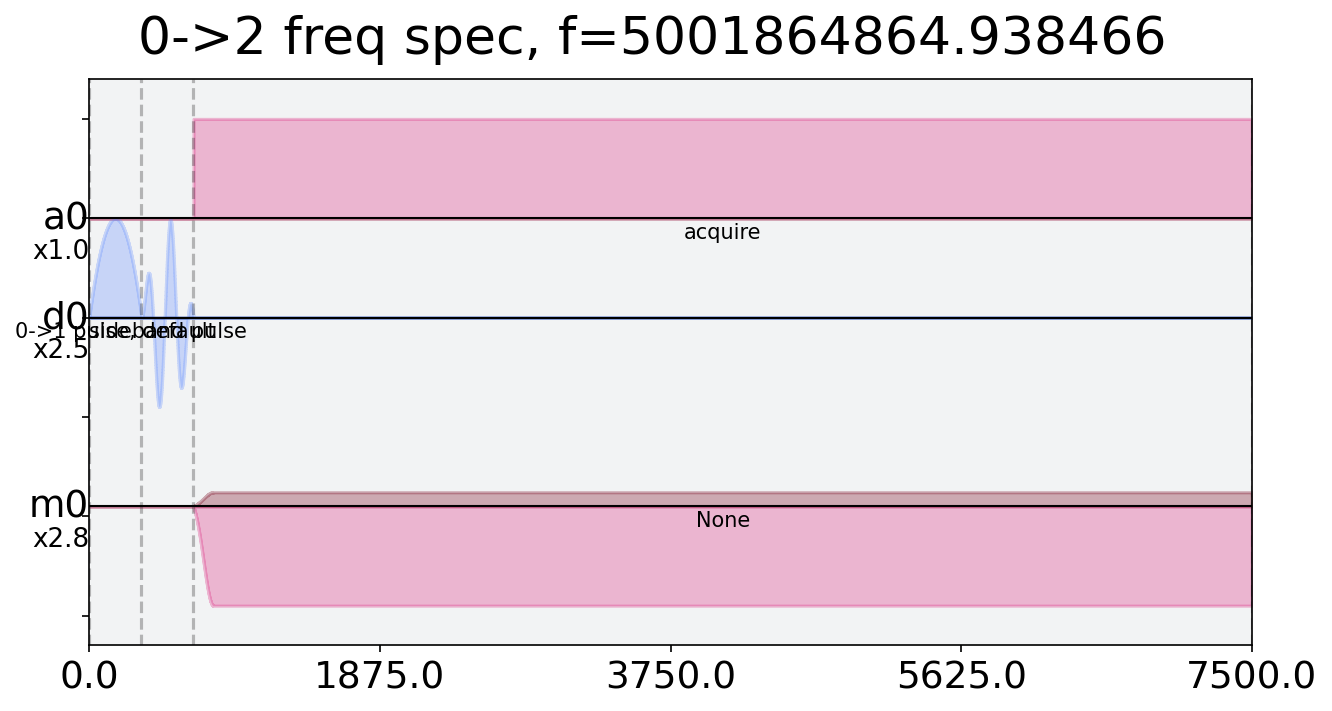

In [100]:
from qiskit.pulse import Waveform
def apply_sideband(pulse, mod_freq, carrier_freq, duration):
    t_samples = np.linspace(0, dt*duration, duration)
    sine_pulse = np.sin(2*np.pi*(mod_freq-carrier_freq)*t_samples)
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name="sideband pulse")
    
    return sideband_pulse

freq_offset = 0 ##342*MHz # for Rome
excited_sweep_freqs = qubit_01_freq_cal - freq_offset + np.linspace(-30*MHz, 30*MHz, 75) #np.linspace(-30e6, 30e6, 75)
sched_12 = []

# carrier pulse
freq_sweep_pulse_carrier = gaussian(
    duration=drive_samples,
    amp=drive_power,
    sigma=drive_sigma,
    name="0->1 pulse, default")

for freq in excited_sweep_freqs:
    # make modulated pulse
    freq_sweep_12_pulse = apply_sideband(freq_sweep_pulse_carrier, freq, qubit_01_freq_cal, drive_samples)

    sched = pulse.Schedule(name=f"0->2 freq spec, f={freq}")
    # Start constructing schedule
    sched |= pulse.Play(freq_sweep_pulse_carrier, drive_chan)
    sched |= pulse.Play(freq_sweep_12_pulse, drive_chan) << sched.duration 
    sched |= measure([qubit], backend, backend_defaults.instruction_schedule_map, 
                     backend_config.meas_map) << sched.duration # shift measurement to after drive pulses
    # End construction
    
    sched_12.append(sched)

sched_12[-1].draw(**plot_options)

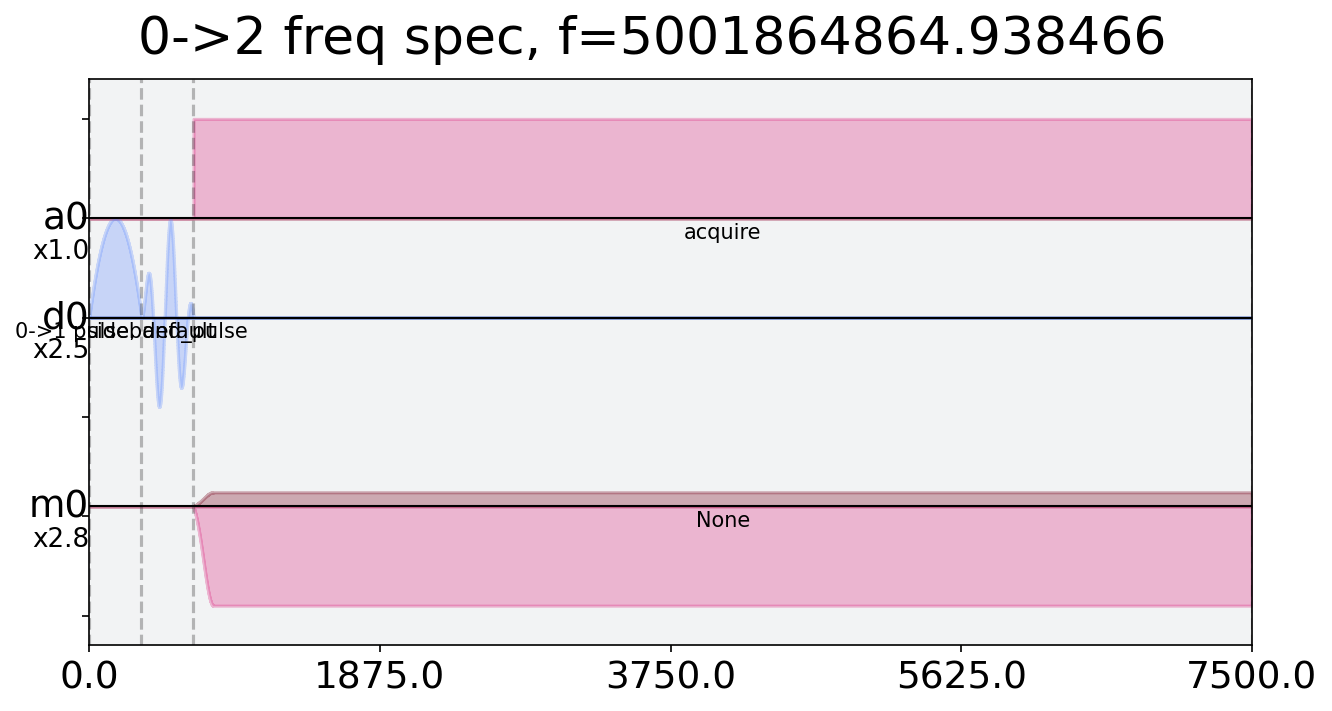

In [108]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-qubit_01_freq_cal)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse  

freq_offset = 0 ##342*MHz # for Rome
excited_sweep_freqs = qubit_01_freq_cal - freq_offset + np.linspace(-400*MHz, 30*MHz, 75) #np.linspace(-30e6, 30e6, 75)
sched_12 = []

# carrier pulse
freq_sweep_pulse_carrier = gaussian(
    duration=drive_samples,
    amp=drive_power,
    sigma=drive_sigma,
    name="0->1 pulse, default")

for freq in excited_sweep_freqs:
    # make modulated pulse
    freq_sweep_12_pulse = apply_sideband(freq_sweep_pulse_carrier, freq)#, qubit_01_freq_cal, drive_samples)

    sched = pulse.Schedule(name=f"0->2 freq spec, f={freq}")
    # Start constructing schedule
    sched |= pulse.Play(freq_sweep_pulse_carrier, drive_chan)
    sched |= pulse.Play(freq_sweep_12_pulse, drive_chan) << sched.duration 
    sched |= measure([qubit], backend, backend_defaults.instruction_schedule_map, 
                     backend_config.meas_map) << sched.duration # shift measurement to after drive pulses
    # End construction
    
    sched_12.append(sched)

sched_12[-1].draw(**plot_options)

In [109]:
excited_freq_sweep_program = assemble(sched_12,
                                      backend=backend, 
                                      meas_level=1,
                                      meas_return='avg',
                                      shots=1024,
                                      schedule_los=[{drive_chan: qubit_01_freq_cal}]
                                                     * len(excited_sweep_freqs))

excited_freq_sweep_job = backend.run(excited_freq_sweep_program)
excited_freq_sweep_job.update_name("frequency sweep 1->2")
job_monitor(excited_freq_sweep_job)

<ipython-input-109-1d5599a0ac1e>:9: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  excited_freq_sweep_job = backend.run(excited_freq_sweep_program)


Job Status: job has successfully run


### Estimating $|1\rangle\rightarrow|2\rangle$ frequency

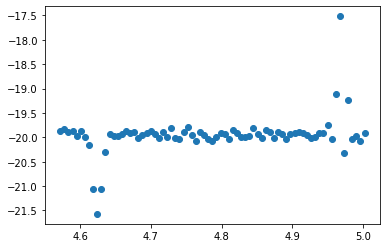

In [127]:
result = excited_freq_sweep_job.result()
excited_freq_sweep_data = [result.get_memory(i)[0]*scale_factor for i in range(len(result.results))]
plt.scatter(excited_sweep_freqs/GHz,excited_freq_sweep_data)
qubit_12_freq_approx = excited_sweep_freqs[np.argmin(excited_freq_sweep_data)]

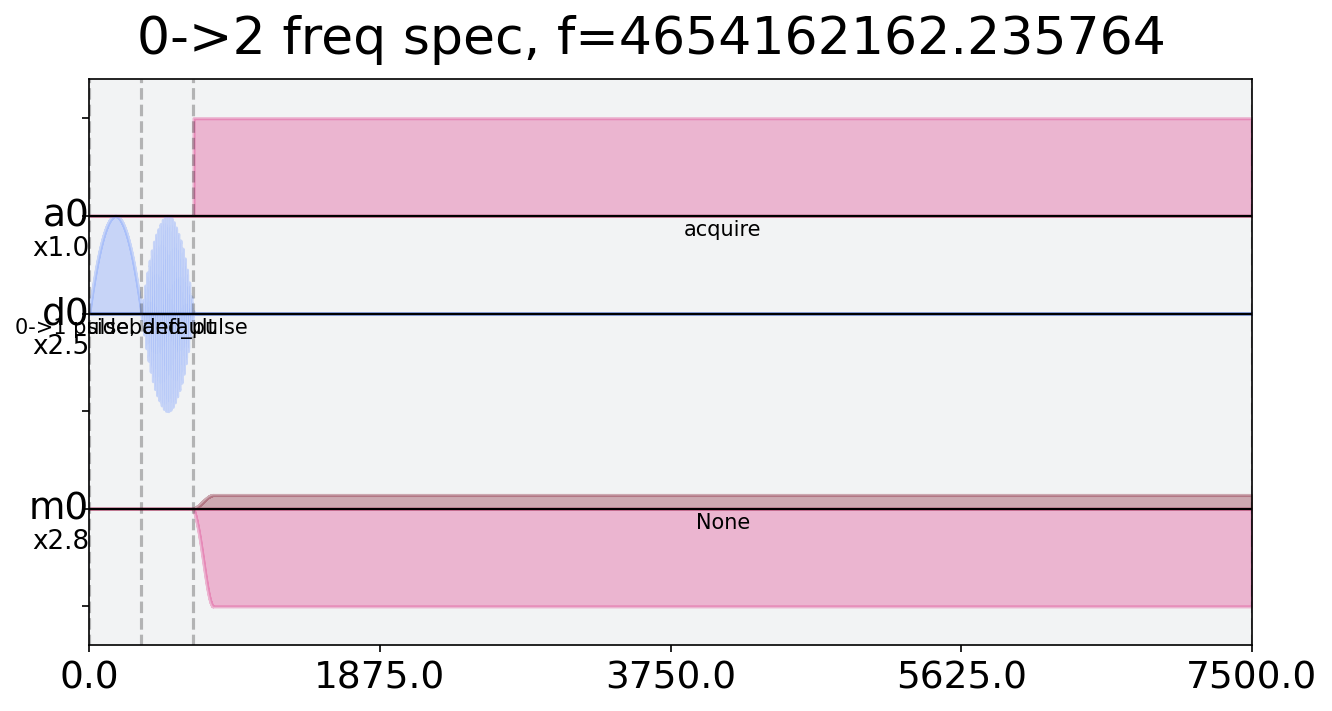

In [128]:
freq_offset = 0 ##342*MHz # for Rome
excited_sweep_freqs = qubit_12_freq_approx - freq_offset + np.linspace(-30*MHz, 30*MHz, 75) #np.linspace(-30e6, 30e6, 75)
sched_12 = []

# carrier pulse
freq_sweep_pulse_carrier = gaussian(
    duration=drive_samples,
    amp=drive_power,
    sigma=drive_sigma,
    name="0->1 pulse, default")

for freq in excited_sweep_freqs:
    # make modulated pulse
    freq_sweep_12_pulse = apply_sideband(freq_sweep_pulse_carrier, freq)#, qubit_01_freq_cal, drive_samples)

    sched = pulse.Schedule(name=f"0->2 freq spec, f={freq}")
    # Start constructing schedule
    sched |= pulse.Play(freq_sweep_pulse_carrier, drive_chan)
    sched |= pulse.Play(freq_sweep_12_pulse, drive_chan) << sched.duration 
    sched |= measure([qubit], backend, backend_defaults.instruction_schedule_map, 
                     backend_config.meas_map) << sched.duration # shift measurement to after drive pulses
    # End construction
    
    sched_12.append(sched)

sched_12[-1].draw(**plot_options)

In [129]:
excited_freq_sweep_program = assemble(sched_12,
                                      backend=backend, 
                                      meas_level=1,
                                      meas_return='avg',
                                      shots=1024,
                                      schedule_los=[{drive_chan: qubit_01_freq_cal}]
                                                     * len(excited_sweep_freqs))

excited_freq_sweep_job = backend.run(excited_freq_sweep_program)
excited_freq_sweep_job.update_name("frequency sweep 1->2")
job_monitor(excited_freq_sweep_job)

<ipython-input-129-1d5599a0ac1e>:9: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  excited_freq_sweep_job = backend.run(excited_freq_sweep_program)


Job Status: job has successfully run


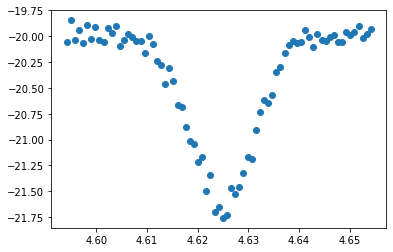

In [130]:
result = excited_freq_sweep_job.result()
excited_freq_sweep_data = [result.get_memory(i)[0]*scale_factor for i in range(len(result.results))]
plt.scatter(excited_sweep_freqs/GHz,excited_freq_sweep_data)

Fit parameters: [-4.38923577e+07  4.62492561e+09  7.20753451e+06 -1.97950607e+01]


/home/whatsis/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/whatsis/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


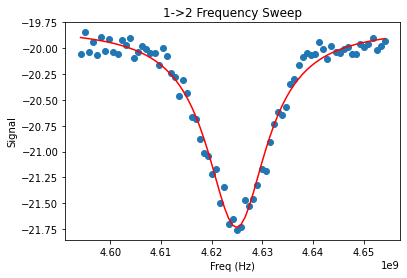

In [133]:
result = excited_freq_sweep_job.result()
excited_freq_sweep_data = [result.get_memory(i)[0]*scale_factor for i in range(len(result.results))]

fitparams, _ = curve_fit(lorentzian,
                         excited_sweep_freqs,
                         excited_freq_sweep_data,
                         [1e7, qubit_12_freq_approx, 1e6, 31])
print(f"Fit parameters: {fitparams}")

y_fit = lorentzian(excited_sweep_freqs, *fitparams)

plt.scatter(excited_sweep_freqs,excited_freq_sweep_data)
plt.plot(excited_sweep_freqs, y_fit, color='red')

plt.title("1->2 Frequency Sweep")
plt.xlabel("Freq (Hz)")
plt.ylabel("Signal")
plt.show()

### Calibrating $|1\rangle\rightarrow|2\rangle$ frequency

In [134]:
qubit_12_freq_cal = fitparams[1]
print(f"Updated qubit frequency from {qubit_12_freq_approx/GHz} to {qubit_12_freq_cal/GHz} GHz")

Updated qubit frequency from 4.624162162235764 to 4.624925606368087 GHz


## Rabi Experiment: $|0\rangle \rightarrow |2\rangle$

In [139]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = -1.0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

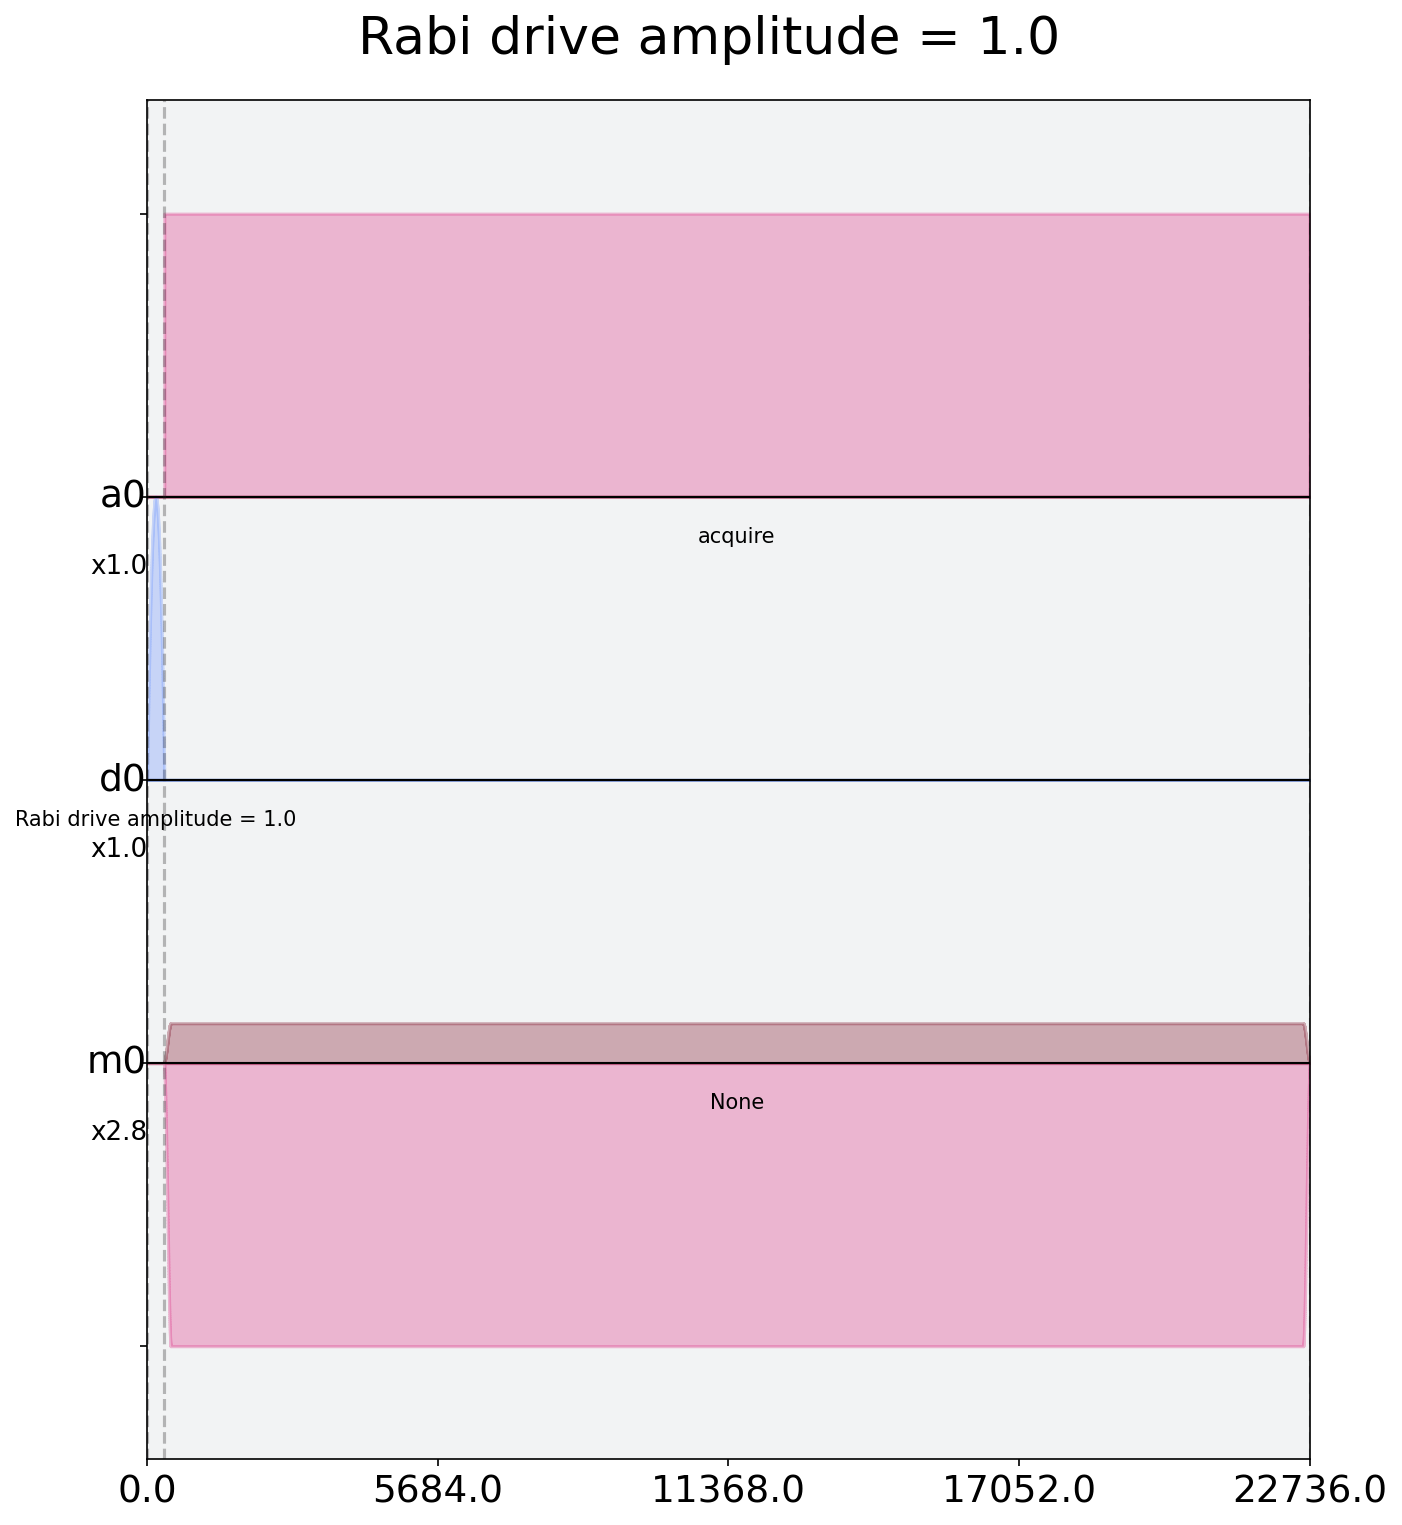

In [140]:
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += pulse.Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure([qubit], backend, backend_defaults.instruction_schedule_map, backend_config.meas_map) << this_schedule.duration
    rabi_schedules.append(this_schedule)
    
rabi_schedules[-1].draw(label=True)


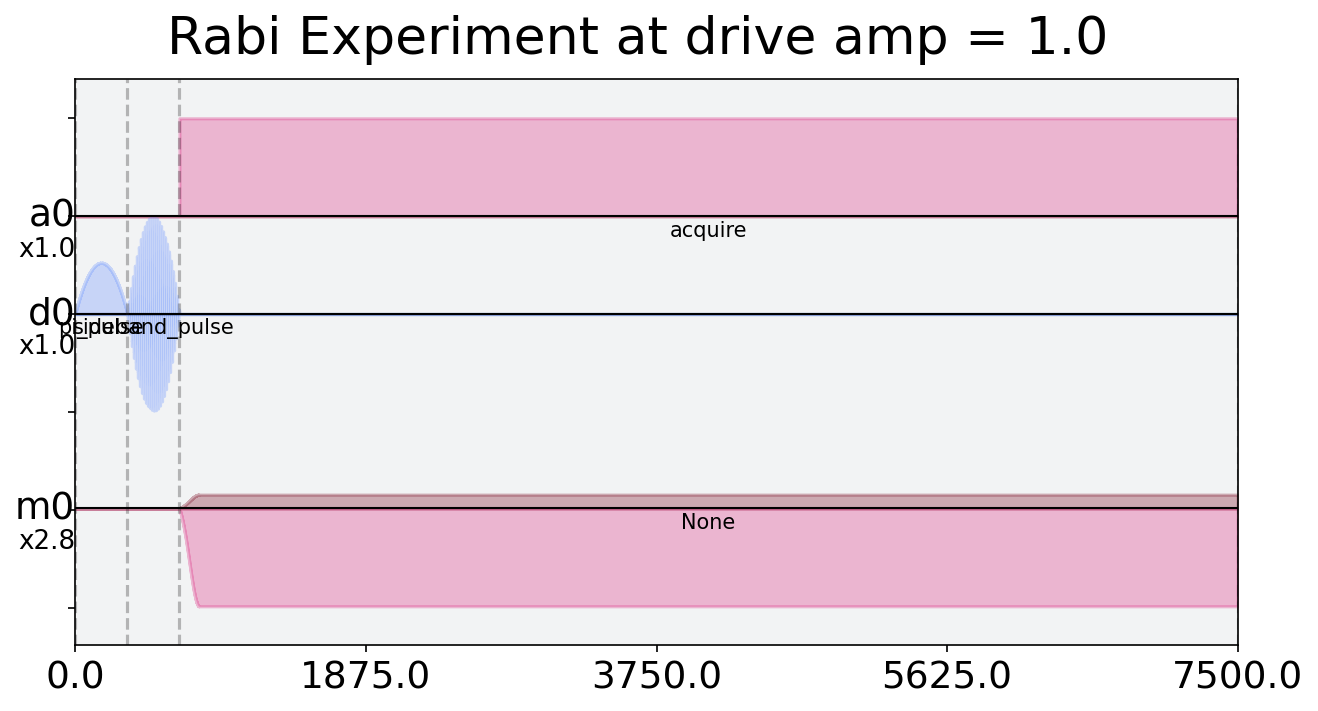

In [141]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-qubit_01_freq_cal)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse  

# Create schedule
rabi_12_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    
    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma/2,
                                       amp=drive_amp,
                                       name='base_12_pulse')
    # apply sideband at the 1->2 frequency
    rabi_12_pulse = apply_sideband(base_12_pulse, qubit_12_freq_cal)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(pi_pulse_01, drive_chan) # 0->1
    schedule |= pulse.Play(rabi_12_pulse, drive_chan) << schedule.duration # 1->2 Rabi pulse
    schedule |= measure([qubit], backend, backend_defaults.instruction_schedule_map, 
                     backend_config.meas_map) << schedule.duration # shift measurement to after drive pulse
    
    rabi_12_schedules.append(schedule)
    
rabi_12_schedules[-1].draw(**plot_options)

In [142]:
# Assemble the schedules into a program
# Note: The LO frequency is at cal_qubit_freq to support the 0->1 pi pulse;
# it is modified for the 1->2 pulse using sidebanding

rabi_12_expt_program = assemble(rabi_12_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: qubit_01_freq_cal}]
                                               * num_rabi_points)

rabi_12_job = backend.run(rabi_12_expt_program)
rabi_12_job.update_name("rabi 1->2")
job_monitor(rabi_12_job)

<ipython-input-142-517633b71749>:13: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  rabi_12_job = backend.run(rabi_12_expt_program)


Job Status: job has successfully run


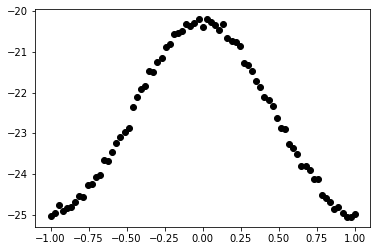

In [143]:
# Note: We only plot the real part of the signal.

rabi_12_results = rabi_12_job.result()

rabi_12_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_12_values.append(rabi_12_results.get_memory(i)[qubit]*scale_factor)

plt.scatter(drive_amps, rabi_12_values, color='black')

In [154]:
#rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                            rabi_12_values, 
                            lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                            [5, 5, 5, 0])

/home/whatsis/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


/home/whatsis/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


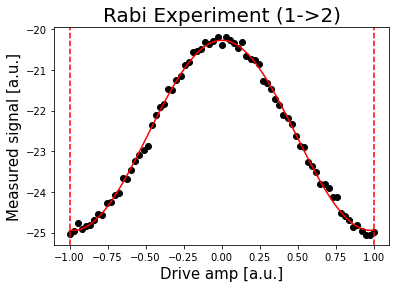

In [250]:
plt.scatter(drive_amps, rabi_12_values, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
# account for phi in computing pi amp
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])

plt.axvline(-1, color='red', linestyle='--')
plt.axvline(1, color='red', linestyle='--')
#plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
#plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

### Calibrating Amplitude for $|1\rangle\rightarrow|2\rangle$ $\pi$ pulse

In [175]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq_cal/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.6249256 GHz.
Pi Amplitude (1->2) = 0.9794695882925166


In [176]:
pi_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq_cal)

## Build the ($|0\rangle,\ |1\rangle,\ |2\rangle$) discriminator

In [177]:
# Create the three schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="cal_0")
zero_schedule |= measure([qubit], backend, backend_defaults.instruction_schedule_map, 
                     backend_config.meas_map)

# Excited state schedule
one_schedule = pulse.Schedule(name="cal_1")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan)
one_schedule |= measure([qubit], backend, backend_defaults.instruction_schedule_map, 
                     backend_config.meas_map) << one_schedule.duration

# Excited state schedule
two_schedule = pulse.Schedule(name="cal_2")
two_schedule |= pulse.Play(pi_pulse_01, drive_chan)
two_schedule |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule.duration
two_schedule |= measure([qubit], backend, backend_defaults.instruction_schedule_map, 
                     backend_config.meas_map) << two_schedule.duration

In [178]:
# Assemble the schedules into a program
IQ_012_program = assemble([zero_schedule, one_schedule, two_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: qubit_01_freq_cal}] * 3)

IQ_012_job = backend.run(IQ_012_program)
job_monitor(IQ_012_job)

<ipython-input-178-b6eb4eb2f96a>:9: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  IQ_012_job = backend.run(IQ_012_program)


Job Status: job has successfully run


In [625]:
# Get job data (single); split for zero, one and two
result = IQ_012_job.result()

# Single shots result
IQ_012_data = [result.get_memory(i)[:,0]*scale_factor for i in range(len(result.results))]

zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [216]:
with open('res_1_012.npy', 'wb') as f:
    np.save(f, zero_data)
    np.save(f, one_data)
    np.save(f, two_data)


### IQ Plot

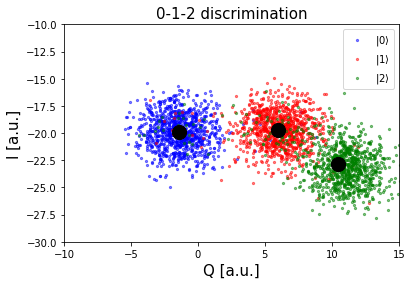

In [181]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    mean_zero = np.mean(zero_data)
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

IQ_012_plot(-10, 15, -30, -10)

## TESTING DIFFERENT CLASSIFIERS

### Defining Discriminator and False Error Rates

In [592]:
from qiskit.ignis.measurement.discriminator.filters import DiscriminationFilter

def get_accuracy(counts):
    accuracy = []
    for ind, cnt in enumerate(counts):
        #print(cnt)
        accuracy.append(1-cnt[bin(ind).replace("0b", "")]/NUM_SHOTS) ## FALSE ERROR RATE
    #print(accuracy)
    return accuracy

discs012 = {}

### Linear Discriminant Analysis

LDA makes predictions by estimating the probability that a new set of inputs belongs to each class. The class that gets the highest probability is the output class and a prediction is made. The model uses Bayes Theorem to estimate the probabilities.

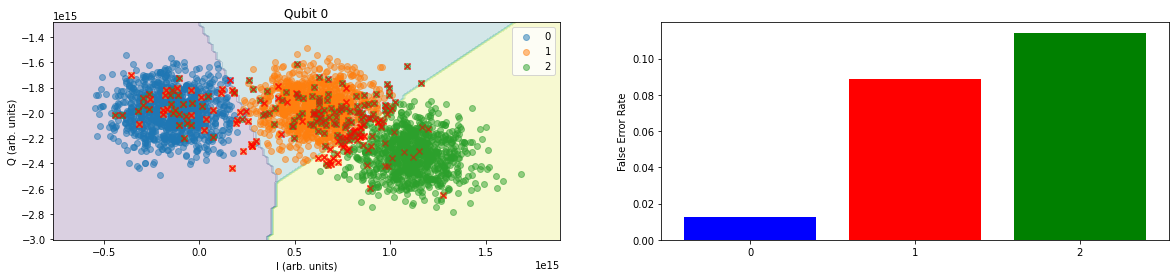

In [626]:
fig, ax = plt.subplots(1, 2, figsize=(20,4))

discs012['LDA'] = LinearIQDiscriminator(result, qubit_mask=[0], schedules=None)
discs012['LDA'].plot(ax[0], show_boundary=True, flag_misclassified=True)
ax[1].bar([str(ind) for ind in range(3)], 
          get_accuracy(DiscriminationFilter(discs012['LDA']).apply(result).get_counts()), 
          color=['blue', 'red', 'green'])
ax[1].set_ylabel("False Error Rate")
plt.show()

### Quadaratic Discriminant Analysis

QDA also makes predictions by estimating the probability that a new set of inputs belongs to each class. The class that gets the highest probability is the output class and a prediction is made. The model uses Bayes Theorem to estimate the probabilities.

**Note**: LDA is a special case of QDA, where the Gaussians for each class are assumed to share the same covariance matrix.

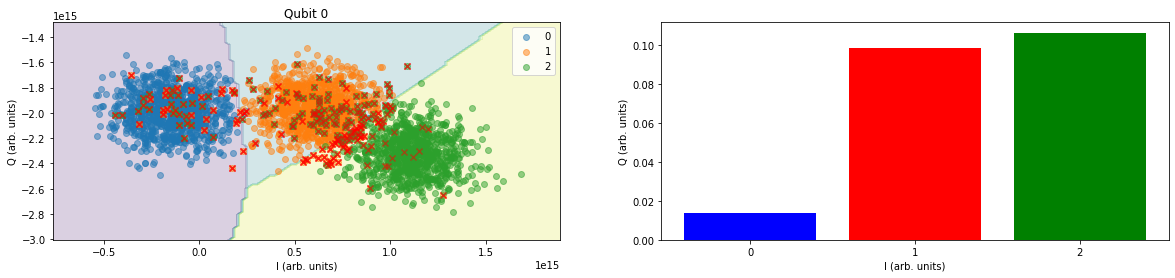

In [594]:
fig, ax = plt.subplots(1, 2, figsize=(20,4))

discs012['QDA'] = QuadraticIQDiscriminator(result, qubit_mask=[0], schedules=None)
discs012['QDA'].plot(ax, show_boundary=True, flag_misclassified=True)
ax[1].bar([str(ind) for ind in range(3)], 
          get_accuracy(DiscriminationFilter(discs012['QDA']).apply(result).get_counts()), 
          color=['blue', 'red', 'green'])
plt.show()

### Support Vector Machines

SVMs are used to find a hyperplane in $N$ (or some high) dimensional space that distinctly classifies the data points.

**Note**: The multiclass support is handled according to a one-vs-one scheme.

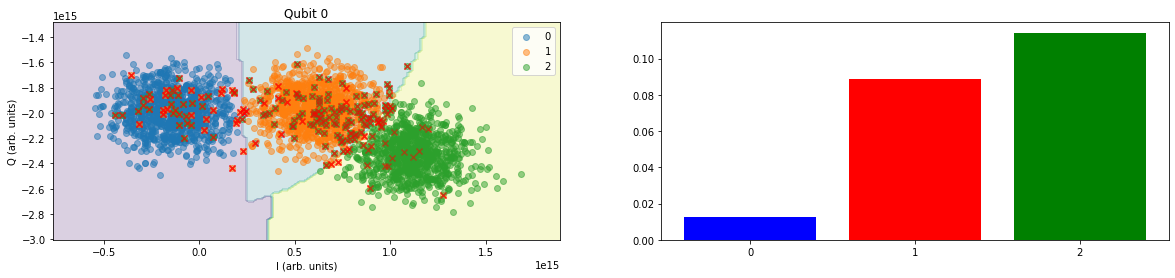

In [595]:
from sklearn.svm import SVC

svc = SVC(C=1., kernel="rbf", gamma="scale")
fig, ax = plt.subplots(1, 2, figsize=(20,4))

discs012['SVC'] = SklearnIQDiscriminator(svc, result, qubit_mask=[0], schedules=None)
discs012['SVC'].plot(ax[0], show_boundary=True, flag_misclassified=True)
ax[1].bar([str(ind) for ind in range(3)], 
          get_accuracy(DiscriminationFilter(discs012['LDA']).apply(result).get_counts()), 
          color=['blue', 'red', 'green'])
plt.show()

### Gaussian Naive Bayes 

Naive Bayes classifiers are a collection of classification algorithms based on Bayes’ Theorem. It is not a single algorithm but a family of algorithms where all of them share a common principle, i.e. every pair of features being classified is independent of each other.

**Note**: If in the QDA model one assumes that the covariance matrices are diagonal, then the inputs are assumed to be conditionally independent in each class, and the resulting classifier is equivalent to the Gaussian Naive Bayes classifier

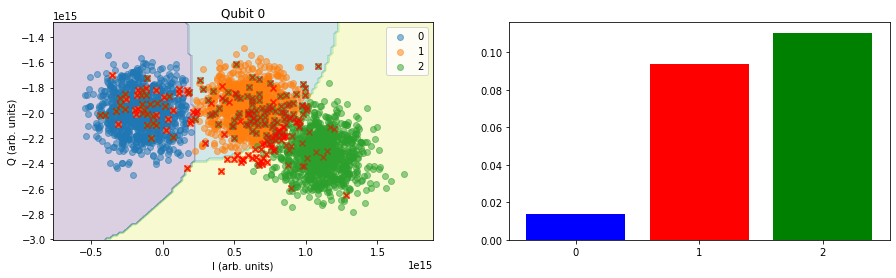

In [596]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
fig, ax = plt.subplots(1, 2, figsize=(15,4))

discs012['GNB'] = SklearnIQDiscriminator(GNB, result, qubit_mask=[0], schedules=None)
discs012['GNB'].plot(ax[0], show_boundary=True, flag_misclassified=True)
ax[1].bar([str(ind) for ind in range(3)], 
          get_accuracy(DiscriminationFilter(discs012['GNB']).apply(result).get_counts()), 
          color=['blue', 'red', 'green'])
plt.show()

### Decision Trees

A Decision Tree is constructed by asking a serious of questions with respect to a record of the dataset we have got. Each time an answer is received, a follow-up question is asked until a conclusion about the class label of the record

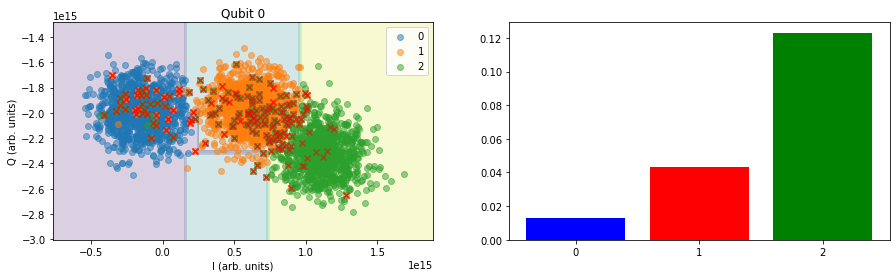

In [597]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=5)
fig, ax = plt.subplots(1, 2, figsize=(15,4))

discs012['DTC'] = SklearnIQDiscriminator(dtc, result, qubit_mask=[0], schedules=None)
discs012['DTC'].plot(ax[0], show_boundary=True, flag_misclassified=True)
ax[1].bar([str(ind) for ind in range(3)], 
          get_accuracy(DiscriminationFilter(discs012['DTC']).apply(result).get_counts()), 
          color=['blue', 'red', 'green'])
plt.show()

### Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

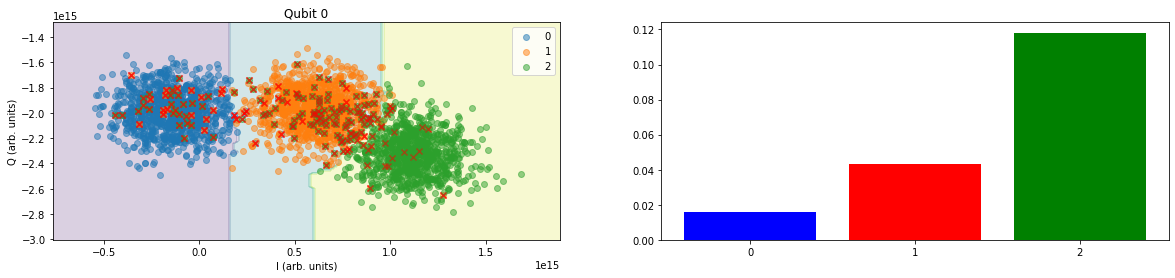

In [598]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(max_depth=5, n_estimators=100)
fig, ax = plt.subplots(1, 2, figsize=(20,4))

discs012['RFC'] = SklearnIQDiscriminator(RFC, result, qubit_mask=[0], schedules=None)
discs012['RFC'].plot(ax[0], show_boundary=True, flag_misclassified=True)
ax[1].bar([str(ind) for ind in range(3)], 
          get_accuracy(DiscriminationFilter(discs012['RFC']).apply(result).get_counts()), 
          color=['blue', 'red', 'green'])
plt.show()

### Ada Boost

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

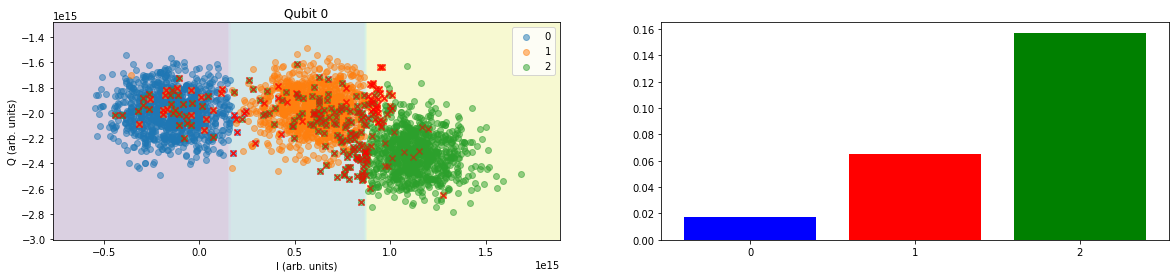

In [599]:
from sklearn.ensemble import AdaBoostClassifier

ABC = AdaBoostClassifier()
fig, ax = plt.subplots(1, 2, figsize=(20,4))

discs012['ABC'] = SklearnIQDiscriminator(ABC, result, qubit_mask=[0], schedules=None)
discs012['ABC'].plot(ax[0], show_boundary=True, flag_misclassified=True)
ax[1].bar([str(ind) for ind in range(3)], 
          get_accuracy(DiscriminationFilter(discs012['ABC']).apply(result).get_counts()), 
          color=['blue', 'red', 'green'])
plt.show()

### Multi-Layer Perceptron

A multilayer perceptron (MLP) is a class of feedforward artificial neural network (ANN). 

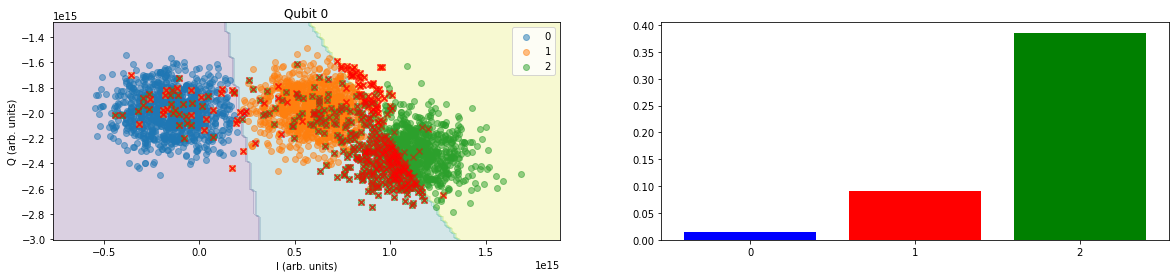

In [615]:
from sklearn.neural_network import MLPClassifier
    
MLP = MLPClassifier(hidden_layer_sizes=1000, max_iter=1000)
fig, ax = plt.subplots(1, 2, figsize=(20,4))

discs012['MLP'] = SklearnIQDiscriminator(MLP, result, qubit_mask=[0], schedules=None)
discs012['MLP'].plot(ax[0], show_boundary=True, flag_misclassified=True)
ax[1].bar([str(ind) for ind in range(3)], 
          get_accuracy(DiscriminationFilter(discs012['MLP']).apply(result).get_counts()), 
          color=['blue', 'red', 'green'])
plt.show()

### K-Neighbors

K-nearest neighbors algorithm (k-NN) is a non-parametric classification method.

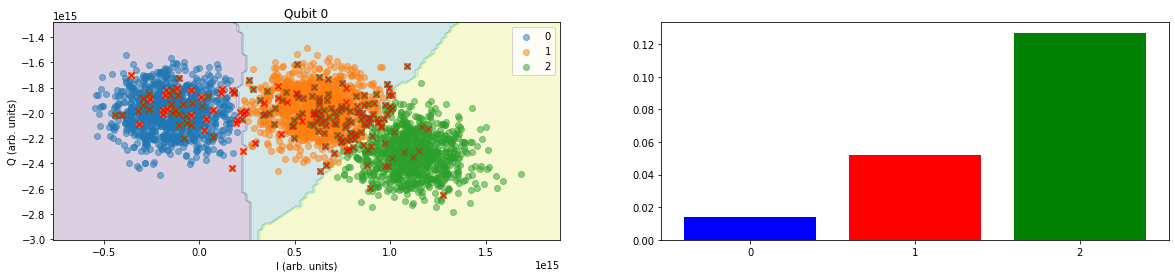

In [601]:
from sklearn.neighbors import KNeighborsClassifier
    
KNC = KNeighborsClassifier(15)
fig, ax = plt.subplots(1, 2, figsize=(20,4))

discs012['KNC'] = SklearnIQDiscriminator(KNC, result, qubit_mask=[0], schedules=None)
discs012['KNC'].plot(ax[0], show_boundary=True, flag_misclassified=True)
ax[1].bar([str(ind) for ind in range(3)], 
          get_accuracy(DiscriminationFilter(discs012['KNC']).apply(result).get_counts()), 
          color=['blue', 'red', 'green'])
plt.show()

### Kernel Fisher Discriminant Analysis

This is kernelized version of standard discriminant analysis methods.

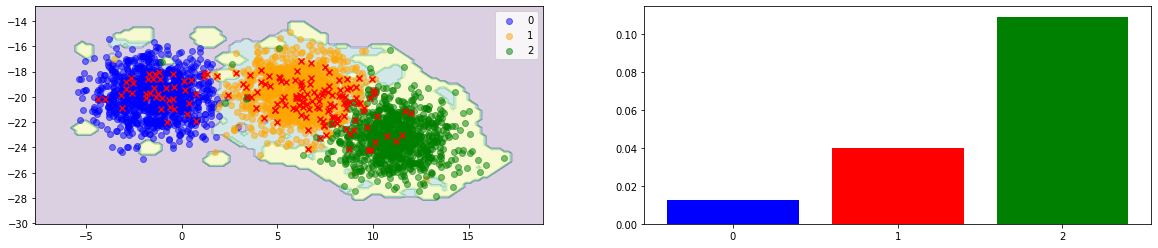

In [607]:
from kfda import Kfda

fig, ax = plt.subplots(1, 2, figsize=(20,4))

cls = Kfda(kernel='rbf', n_components=2, gamma=1)
discs012['CLS'] = SklearnIQDiscriminator(cls, result, qubit_mask=[0], schedules=None)
x_data = np.array(discs012['CLS']._xdata)*scale_factor
y_data = np.array(discs012['CLS']._ydata)
cls.fit(x_data, y_data)

X, Y = np.meshgrid(xx[0], yy[:,0])
X_grid = np.asarray([np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())])
zz = cls.predict(X_grid)
Z = np.array(zz).astype(float).reshape(xx.shape)
ax[0].contourf(X,Y,Z, alpha=0.2)

y_disc = cls.predict(x_data)
bardata = []
for idx, cl in enumerate(['blue', 'orange', 'green']):
    x_cl = x_data[y_disc==str(idx)]
    bardata.append(len(np.where(y_data[np.where(y_disc != y_data)] == str(idx))[0])/NUM_SHOTS)
    ax[0].scatter(x_cl[:,0], x_cl[:,1], color=cl, alpha=0.5, label=str(idx))
    ax[0].legend()

misclassified = x_data[y_disc != y_data]
ax[0].scatter(misclassified[:, 0],
           misclassified[:, 1],
           color='r', marker='x')

for idx, cl in enumerate(['blue', 'red', 'green']):
    
    y_data[np.where(y_disc != y_data)]

ax[1].bar([str(ind) for ind in range(3)], bardata, color=['blue', 'red', 'green'])
plt.show()

In [636]:
import dataframe_image as dfi
dfi.export(df, 'df_styled.pdf')

In [634]:
import pandas as pd
datas = []

for key, vals in discs012.items():
    if key != "CLS":
        false_err = get_accuracy(DiscriminationFilter(vals).apply(result).get_counts())
        data = {"Classifier":key, "0":false_err[0], "1":false_err[1], "2":false_err[2]}
    else:
        false_err = bardata
        data = {"Classifier":"KFDA", "0":false_err[0], "1":false_err[1], "2":false_err[2]}
    datas.append(data)

df = pd.DataFrame(datas)
df = df.style.background_gradient()
df

,Classifier,0,1,2
0,LDA,0.012695,0.088867,0.114258
1,QDA,0.013672,0.098633,0.106445
2,SVC,0.013672,0.055664,0.126953
3,GNB,0.013672,0.093750,0.110352
4,DTC,0.012695,0.042969,0.123047
5,RFC,0.015625,0.042969,0.118164
6,ABC,0.017578,0.065430,0.157227
7,MLP,0.013672,0.090820,0.385742
8,KNC,0.013672,0.051758,0.126953
9,KFDA,0.012695,0.040039,0.109375


## ESP Classification

In [564]:
from qiskit.ignis.measurement.discriminator.iq_discriminators import IQDiscriminationFitter

class ESPIQDiscriminator(IQDiscriminationFitter):
    """
    An Excited State Promoted Readout discriminator for IQ data that
    takes an multiclass sklearn classifier as an argument.
    """

    def __init__(self, cal_results: Union[Result, List[Result]],
                 qubit_mask: List[int], classifier = None, 
                 expected_states: List[str] = None, standardize: bool = False,
                 schedules: Union[List[str], List[Schedule]] = None):
       s """
        Args:
            cal_results (Union[Result, List[Result]]): calibration results,
                Result or list of Result used to fit the discriminator.
            qubit_mask (List[int]): determines which qubit's level 1 data to
                use in the discrimination process.
            expected_states (List[str]): a list that should have the same
                length as schedules. All results in cal_results are used if
                schedules is None. expected_states must have the corresponding
                length.
            classifier (Classifier):
                An sklearn classifier to train and do the discrimination. The
                classifier must have a fit method and a predict method. If 
                nothing is provided, a default classifier will be used.
            standardize (bool): if true the discriminator will standardize the
                xdata using the internal method _scale_data.
            schedules (Union[List[str], List[Schedule]]): The schedules or a
                subset of schedules in cal_results used to train the
                discriminator. The user may also pass the name of the schedules
                instead of the schedules. If schedules is None, then all the
                schedules in cal_results are used.
        """
        if classifier is not None:
            self._type_check_classifier(classifier)
        else:
            pass
            #    classifier = some_default_classifier
            
        self._classifier = classifier
        
        self._check_classes(cal_results) #Number of schedules
        
        # Also sets the x and y data.
        IQDiscriminationFitter.__init__(self, cal_results, qubit_mask,
                                        expected_states, standardize,
                                        schedules)
        
        self._description = (
            '{} IQ discriminator for measurement level 1.'.format(
                classifier.__class__.__name__))

        self.fit()


    @staticmethod
    def _type_check_classifier(classifier):
        for name in ['fit', 'predict']:
            if not callable(getattr(classifier, name, None)):
                raise QiskitError(
                    'Classifier of type "{}" does not have a callable "{}"'
                    ' method.'.format(type(classifier).__name__, name)
                )

    @staticmethod
    def _check_classes(calc_results):
        
        if isinstance(calc_results, list):
            if len(calc_results) < 3 or max([len(res.results) for res in calc_results]) < 3:
                 raise QiskitError(
                    'ESP requires results from at least 3 different schedules. Only "{}" provided.'
                    ' method.'.format(max([len(res.results) for res in calc_results]))
                )
        else:
            if len(calc_results.results) < 3:
                 raise QiskitError(
                    'ESP requires results from at least 3 different schedules. Only "{}" provided.'
                    ' method.'.format(len(calc_results.results))
                )            

    def fit(self):
        """ Fits the discriminator using self._xdata and self._ydata. """
        if len(self._xdata) == 0:
            return

        self._classifier.fit(self._xdata, self._ydata)
        self._fitted = True


    def discriminate(self, x_data: List[List[float]]) -> List[str]:
        """Applies the discriminator to x_data.

        Args:
            x_data (List[List[float]]): list of features. Each feature is
                                        itself a list.

        Returns:
            the discriminated x_data as a list of labels.
        """
        return self._classifier.predict(x_data)

In [565]:
from qiskit.ignis.measurement.discriminator.iq_discriminators import IQDiscriminationFitter

class ESPIQDiscriminator(IQDiscriminationFitter):
    """
    An Excited State Promoted Readout discriminator for IQ data that
    takes an multiclass sklearn classifier as an argument.
    """

    def __init__(self, cal_results: Union[Result, List[Result]],
                 qubit_mask: List[int], classifier = None, 
                 expected_states: List[str] = None, standardize: bool = False,
                 schedules: Union[List[str], List[Schedule]] = None):
        """
        Args:
            cal_results (Union[Result, List[Result]]): calibration results,
                Result or list of Result used to fit the discriminator.
            qubit_mask (List[int]): determines which qubit's level 1 data to
                use in the discrimination process.
            expected_states (List[str]): a list that should have the same
                length as schedules. All results in cal_results are used if
                schedules is None. expected_states must have the corresponding
                length.
            classifier (Classifier):
                An sklearn classifier to train and do the discrimination. The
                classifier must have a fit method and a predict method. If 
                nothing is provided, a default classifier will be used.
            standardize (bool): if true the discriminator will standardize the
                xdata using the internal method _scale_data.
            schedules (Union[List[str], List[Schedule]]): The schedules or a
                subset of schedules in cal_results used to train the
                discriminator. The user may also pass the name of the schedules
                instead of the schedules. If schedules is None, then all the
                schedules in cal_results are used.
        """
        if classifier is not None:
            self._type_check_classifier(classifier)
        else:
            from sklearn.naive_bayes import GaussianNB
            classifier = GaussianNB()
            
        self._classifier = classifier
        
        self._check_classes(cal_results) #Number of schedules
        
        # Also sets the x and y data.
        IQDiscriminationFitter.__init__(self, cal_results, qubit_mask,
                                        expected_states, standardize,
                                        schedules)
        
        self._description = (
            '{} IQ discriminator for measurement level 1.'.format(
                classifier.__class__.__name__))

        self.fit()


    @staticmethod
    def _type_check_classifier(classifier):
        for name in ['fit', 'predict']:
            if not callable(getattr(classifier, name, None)):
                raise QiskitError(
                    'Classifier of type "{}" does not have a callable "{}"'
                    ' method.'.format(type(classifier).__name__, name)
                )

    @staticmethod
    def _check_classes(calc_results):
        
        if isinstance(calc_results, list):
            if len(calc_results) < 3 or max([len(res.results) for res in calc_results]) < 3:
                 raise QiskitError(
                    'ESP requires results from at least 3 different schedules. Only "{}" provided.'
                    ' method.'.format(max([len(res.results) for res in calc_results]))
                )
        else:
            if len(calc_results.results) < 3:
                 raise QiskitError(
                    'ESP requires results from at least 3 different schedules. Only "{}" provided.'
                    ' method.'.format(len(calc_results.results))
                )            

    def fit(self):
        """ Fits the discriminator using self._xdata and self._ydata. """
        if len(self._xdata) == 0:
            return

        self._classifier.fit(self._xdata, self._ydata)
        self._fitted = True


    def discriminate(self, x_data: List[List[float]]) -> List[str]:
        """Applies the discriminator to x_data.

        Args:
            x_data (List[List[float]]): list of features. Each feature is
                                        itself a list.

        Returns:
            the discriminated x_data as a list of labels.
        """
        return self._classifier.predict(x_data)

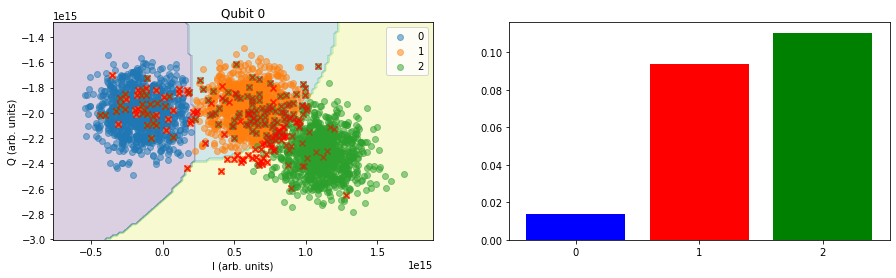

In [566]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
fig, ax = plt.subplots(1, 2, figsize=(15,4))

discs012['GNB'] = ESPIQDiscriminator(result, qubit_mask=[0], schedules=None, classifier=GNB)
discs012['GNB'].plot(ax[0], show_boundary=True, flag_misclassified=True)
ax[1].bar([str(ind) for ind in range(3)], 
          get_accuracy(DiscriminationFilter(discs012['GNB']).apply(result).get_counts()), 
          color=['blue', 'red', 'green'])
plt.show()